# Studies of data reuse: Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization

**Liam Chan-kin**

Paris-Saclay Institute of Neuroscience, CNRS, Université Paris-Saclay, France.

August 2024

----

In this notebook we will look more closely at the EBRAINS dataset "[Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization (v1)](https://search.kg.ebrains.eu/#07554ebd-95a2-46f0-8065-d961d56ce098)", contributed by Machhindra Garad from the Otto-von-Guericke University, Magdeburg, Germany and Volkmar Lessmann from Center for Behavioral Brain Sciences (CBBS), Magdeburg, Germany.

As we can see from the dataset description,

<i>This dataset provides an analysis of electrophysiological feature often observed in recordings from mouse CA1 pyramidal cells that has so far been ignored by experimentalists and modelers. It consists of a large and dynamic increase in the depolarization baseline (i.e., the minimum value of the membrane potential between successive action potentials during a sustained depolarizing input) in response to strong somatic current injections.</i>
More information is available in the [Data Descriptor](https://search.kg.ebrains.eu/instances/07554ebd-95a2-46f0-8065-d961d56ce098).

Bianchi, D., Migliore, R., Vitale, P., Garad, M., Pousinha, P. A., Marie, H., Lessmann, V., & Migliore, M. (2022). Membrane electrical properties of mouse hippocampal CA1 pyramidal neurons during strong inputs. *Biophysical Journal*, **121(4), 644–657**. https://doi.org/10.1016/j.bpj.2022.01.002

In this notebook we will demonstrate how to access the data files and the metadata from this study, and how these data can be analysed and visualised, with the goal of reproducing some of the figures from the article. 

# Downloading the data

Please note that this is a 5.3 MB dataset. Over a slow connection, this could take a long time to download. If running this notebook on a shared resource such as the EBRAINS lab, you may need to delete the downloaded data after use, to avoid taking up too much disk space.

To download the data, we first search for the dataset in the EBRAINS Knowledge Graph using the [fairgraph](https://fairgraph.readthedocs.io/) tool, then download a zip file, and unzip it.

In [4]:
import os
import zipfile
from fairgraph import KGClient
import fairgraph.openminds.core as omcore
import fairgraph.openminds.controlledterms as terms
import fairgraph.openminds.ephys as ephys
import fairgraph.openminds.stimulation as stim
from fairgraph.openminds.core import DatasetVersion
import json

#client = KGClient(host="core.kg.ebrains.eu", token=clb_oauth.get_token())
token = os.environ['KG_AUTH_TOKEN']
client = KGClient(token)
#Choose the Dataset with his version
dataset_title = "Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization."
dataset_version = "v1"

# Use the follow_links parameter from the by_name method to avoid having to resolve every element of the "has_parts" property later
follow_links = {"versions": {"has_parts":{}}}

# Retrieve correct dataset and select his version
dataset = omcore.Dataset.by_name(dataset_title, client, follow_links= follow_links, scope="any")
datasetVersion = dataset.versions if isinstance(dataset.versions, omcore.DatasetVersion) else [dsv for dsv in dataset.versions if dsv.version_identifier == dataset_version][0]
if not os.path.exists("downloads"):
    dataset_path = dataset_version.download("downloads", client, accept_terms_of_use=True)
with zipfile.ZipFile("downloads/d-cc88a377-b456-4673-a449-07b0e7960ffd.zip", "r") as z:
    z.extractall("downloads")

Property 'max_value' should be of type (<class 'float'>,), not <class 'str'>
Property 'min_value' should be of type (<class 'float'>,), not <class 'str'>
Property 'protocols' is required but was not provided.
Property 'max_value' should be of type (<class 'float'>,), not <class 'str'>
Property 'min_value' should be of type (<class 'float'>,), not <class 'str'>
Property 'protocols' is required but was not provided.
Property 'max_value' should be of type (<class 'float'>,), not <class 'str'>
Property 'min_value' should be of type (<class 'float'>,), not <class 'str'>
Property 'protocols' is required but was not provided.
Property 'max_value' should be of type (<class 'float'>,), not <class 'str'>
Property 'min_value' should be of type (<class 'float'>,), not <class 'str'>
Property 'protocols' is required but was not provided.
Property 'max_value' should be of type (<class 'float'>,), not <class 'str'>
Property 'min_value' should be of type (<class 'float'>,), not <class 'str'>
Property '

# Retrieve the Metadata

Metadata is stored in the knowledge graph. We have to find the right path to get there.  

In [5]:
# Select all StimulationActivivities from the DatasetVersion's "has_parts" property, no need to resolve
stimAct =[i for i in datasetVersion.has_parts if isinstance(i,stim.StimulationActivity)]

# Get a list of every EphysStimulus associated to each StimulationActivity in stimAct
ephysStim = []
for act in stimAct:
    if isinstance(act.stimuli, list):
        ephysStim.append([i.resolve(client, scope="any") for i in act.stimuli])
    else:
        ephysStim.append([act.stimuli.resolve(client, scope="any")])
# Note: ephysStim is a list of lists
speEphys= ephysStim[0][0].specifications.resolve(client, scope="any")
Metadata = speEphys.configuration

#Retrieve the metadata of the stimulation in configuration 
current_pulse_amplitudes = json.loads(Metadata)["amplitudes"]

Property 'value' should be of type (<class 'float'>,), not <class 'str'>


## Exploring and visualizing the data

The data contains a number of files with the extension ".abf". There are 2 subjects with differents cells states.

It should be noted that the dataset does not contain the data of laboratory 1 that are shown in the associated paper (Bianchi et al., 2022).

We know from the dataset metadata that these are electrophysiology data, and more specifically that they were obtained with the whole cell patch clamp technique in current clamp mode. We will therefore use the [Neo library](https://neo.readthedocs.io/) to read the data files, since it is able to read data from a large number of electrophysiology file formats.

In [ ]:
from glob import glob
import numpy as np
import pandas as pd
from neo import get_io
from neo import io
from neo.io import AxonIO
from neo.io import AsciiSignalIO

Neo loads data into a hierarchical structure: Blocks contain Segments, which contain the actual data.

Let's look at the structure of the first three files:

In [10]:
for file_path in glob("downloads/*.ABF")[:3]:
    io = get_io(file_path)
    print(io)

ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable


AxonIO: downloads/170529_1b.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/170529_3b.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/170529_2a.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]



These all have a consistent structure: they're in Axon format, contain a single block containing 1 segments.
We know from the associated paper that current pulses of increasing intensity were injected into the neurons, in steps of 50 pA from 0 to 450 pA.

In [11]:
print(current_pulse_amplitudes)
print(f"Number of current pulses: {len(current_pulse_amplitudes)}")

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450]
Number of current pulses: 10


So it seems likely that the segment contains the response of all current pulse. We will assume at this point that all the signals are similar, and take a closer look at one of them.

In [12]:
data = get_io("downloads/170529_1b.ABF").read(lazy=True)
example_signal = data[0].segments[0].analogsignals[0].load()
example_signal

ignoring buggy nTelegraphEnable


AnalogSignal with 1 channels of length 70000; units mV; datatype float32
name: 'Signals'
annotations: {'stream_id': '0'}
sampling rate: 10000.0 Hz
time: 0.0 s to 7.0 s

Now let's plot the data from one of the files:

ignoring buggy nTelegraphEnable


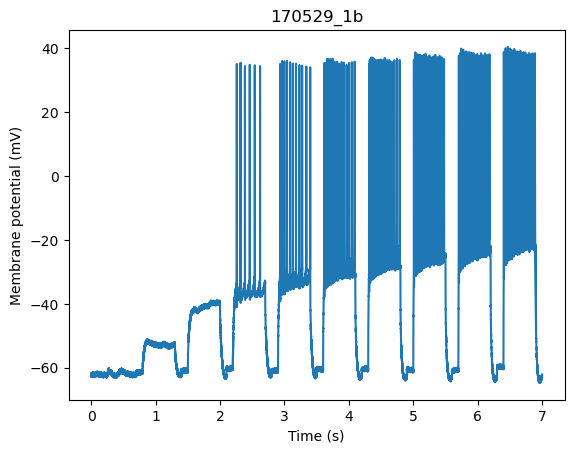

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
#Fonction qui permet d'afficher le graphe selon certains caractéristiques
def plot_data(file_path): 
    #Récupération des données
    data = get_io(file_path).read(lazy=True)
    #Boucle pour lire chaque segment
    for segment in data[0].segments:
        #Stock la valeur de chaque segment dans "signal"
        signal = segment.analogsignals[0].load()
        #Création du graphe du temps selon le potentiel membranaire
        plt.plot(signal.times, signal)
    #Ajout des titres
    plt.title("170529_1b")
    plt.xlabel(f"Time ({signal.times.units.dimensionality})")
    plt.ylabel(f"Membrane potential ({signal.units.dimensionality})")
#Affiche le graphe du fichier demander
plot_data("downloads/170529_1b.ABF")

### Figure 1

Figure 1 show the DBL (depolarization baseline) increases with current injection. To get a closer look at the signals, we can slice the signal to get each current injection independently , and plot only the 700 ms around the current injection:

ignoring buggy nTelegraphEnable


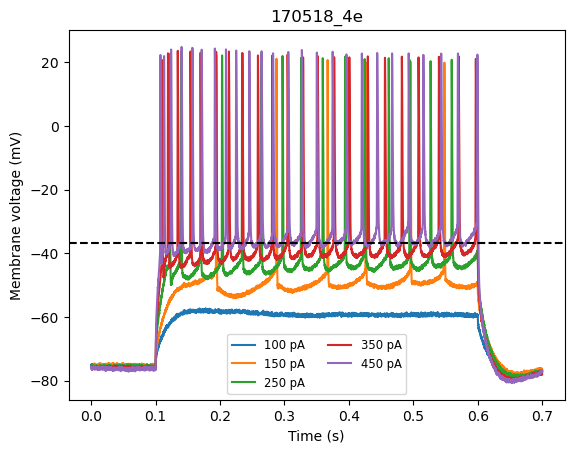

In [14]:
#Fonction qui permet de zoomer sur la zone d'intéret
def plot_data_zoom(file_path):
    #Lecture du fichier et stockage des valeurs
    reader = AxonIO(filename=file_path)
    block = reader.read_block()
    signal_analogique = block.segments[0].analogsignals[0]
    #conversion des valeurs en liste
    signal_numpy = np.array(signal_analogique)
    #création d'un tableau 
    df = pd.DataFrame(signal_numpy, columns=['Valeurs'])
    #Calcule la durée de chaque stimulus 
    part_size = len(df)//len(current_pulse_amplitudes)
    #Décomposition du segment par rapport au nombre d'impulsion
    data_parts = [df[i*part_size:(i+1)*part_size] for i in range(len(current_pulse_amplitudes))]
    #Création d'un tableau vide
    Data_pulse = pd.DataFrame()
    #Remplissage du tableau avec les segments décomposés
    for i, part in enumerate(data_parts):
        Data_pulse.insert(i, i ,data_parts[i]['Valeurs'].tolist())
    #Ajout du temps correcte en index
    times = np.linspace(0,0.7, len(Data_pulse)) 
    Data_pulse= Data_pulse.set_index(times)
    Data_pulse.columns = current_pulse_amplitudes
    indiceselect =[2,3,5,7,9]
    pulse_use = [current_pulse_amplitudes[i] for i in indiceselect]
    pulses = [f"{pulse_use} pA" for pulse_use in pulse_use]
    Data_pulse_graph= Data_pulse[pulse_use]
    Data_pulse_graph.columns = pulses
    Data_pulse_graph= Data_pulse_graph - 10
    fig, lab2= plt.subplots()
    #Création du graphe
    lab2.plot(Data_pulse_graph)
    lab2.axhline(y=-36.72, color='black', linestyle='--', label='-36.72 mV')
    #Ajout des titres
    plt.title("170518_4e")
    plt.xlabel(f"Time ({signal_analogique.times.units.dimensionality})")
    plt.ylabel(f"Membrane voltage ({signal_analogique.units.dimensionality})")
    lab2.legend(Data_pulse_graph,ncol=2, loc=0, fontsize='small')
#Affichage du graphe
plot_data_zoom("downloads/170518_4e.ABF")


Here is the original Figure 1 Laboratory 2 for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article).

We can see the same results between the original figure and the reproduction. The only difference is the legend. Their legends do not correspond to what is written in the methods.

![fig1](original_fig1_lab2.png "Original Figure 1 Lab2")

### Figure 2
Comparaison of each DBL

To detect DBL and take an average for each current injections. We create some functions to have the derivate equal to 0. Then we filtered the results to have the right value before take an average.

Once we have DBL average for each current injections, we apply the same methods for all the files.

In [16]:
# Calcul derivate 
def compute_derivatives(Data_pulse, delta_x=1):
    derivatives = Data_pulse.diff() / delta_x
    return derivatives

# Keep all derivate equal 0
def get_zero_derivative_indices(Data_pulse):
    zero_derivatives = Data_pulse[Data_pulse == 0]
    indices = {col: zero_derivatives[col].dropna().index.tolist() for col in Data_pulse.columns}
    return indices

# Retreive values when derivate equal 0 
def recuperer_valeurs(Data_pulse, indices):
    return Data_pulse.loc[indices]
    
#Keep consecutive value when derivate equal 0
def consec(serie):
    masque = serie == serie.shift(-1)
    masque |= serie == serie.shift(1)
    return serie[masque]
    
#Select the consecutive value
def more_consec(serie_val):
    return [consec(serie) for serie in serie_val]

#Make the means of the value when derivate equal 0 with the consecutive value
def mean_DBL(serie_DBL):
    return [serie.mean() for serie in serie_DBL]


def process_single_file(file_path, current_pulse_amplitudes, delta_x):
    # Lecture du fichier et stockage des valeurs
    reader = AxonIO(filename=file_path)
    block = reader.read_block()
    signal_analogique = block.segments[0].analogsignals[0]
    # Conversion des valeurs en liste
    signal_numpy = np.array(signal_analogique)
    # Création d'un tableau 
    df = pd.DataFrame(signal_numpy, columns=['Valeurs'])
    # Calcule la durée de chaque stimulus 
    part_size = len(df) // len(current_pulse_amplitudes)
    # Décomposition du segment par rapport au nombre d'impulsion
    data_parts = [df[i*part_size:(i+1)*part_size] for i in range(len(current_pulse_amplitudes))]
    # Création d'un tableau vide
    Data_pulse = pd.DataFrame()
    # Remplissage du tableau avec les segments décomposés
    for i, part in enumerate(data_parts):
        Data_pulse.insert(i, i, data_parts[i]['Valeurs'].tolist())
    # Ajout du temps correcte en index
    times = np.linspace(0, 0.7, len(Data_pulse)) 
    Data_pulse = Data_pulse.set_index(times)
    Data_pulse.columns = current_pulse_amplitudes
    Data_pulse = Data_pulse - 10

    # Calculer les dérivées pour chaque colonne
    derivatives_df = compute_derivatives(Data_pulse, delta_x)

    # Garder uniquement les valeurs égales à 0
    zero_derivatives_df = get_zero_derivative_indices(derivatives_df)

    derivatives_dict = {}
    # Boucle pour extraire et assigner chaque dérivée à une variable nommée
    for index in current_pulse_amplitudes:
        derivatives_dict[f'derivate_{index}'] = zero_derivatives_df[index]

    filtered_derivatives_dict = {}
    for key, lst in derivatives_dict.items():
        filtered_list = [value for value in lst if 0.1 <= value <= 0.6]
        filtered_derivatives_dict[key] = filtered_list

    # Accès aux listes filtrées
    derivate_filtered = {index: filtered_derivatives_dict[f'derivate_{index}'] for index in current_pulse_amplitudes}

    # Utilisation pour chaque liste d'indices
    valeurs = [recuperer_valeurs(Data_pulse[index], derivate_filtered[index]) for index in current_pulse_amplitudes]

    # Conserver les valeurs consécutives
    serie_DBL = more_consec(valeurs)

    # Calculer la moyenne des séries
    moyenne_DBL = mean_DBL(serie_DBL)

    return moyenne_DBL

def process_data(file_paths, current_pulse_amplitudes, delta_x=1):
    results = []
    for file_path in file_paths:
        moyenne_DBL = process_single_file(file_path, current_pulse_amplitudes, delta_x)
        results.append(moyenne_DBL)
    
    # Convertir la liste de résultats en DataFrame
    tab_mean = pd.DataFrame(results, columns=current_pulse_amplitudes).transpose()
    tab_mean.columns = [os.path.basename(file_path) for file_path in file_paths]
    
    return tab_mean

file_paths = glob("downloads/*.ABF")
tab_mean = process_data(file_paths, current_pulse_amplitudes, delta_x=1)
row_mean = tab_mean.iloc[2:].mean(axis=1)

ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring buggy nTelegraphEnable
ignoring

Now let's plot the average DBL from all the files.

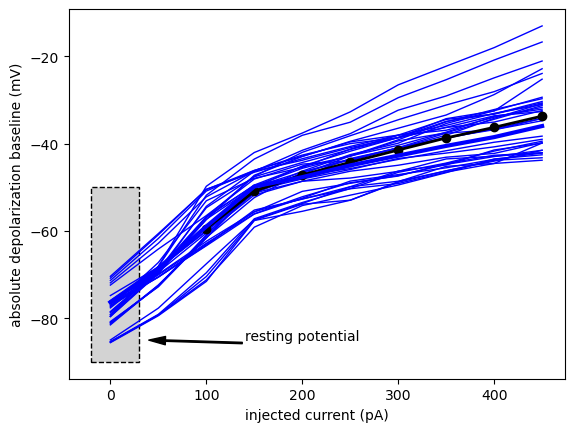

In [17]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.plot(tab_mean, color='blue',linewidth =1)
ax.plot(row_mean,'o-', color='black', linewidth = 2)
ax.plot(tab_mean['170518_4e.ABF'],color='blue', linewidth=3)

rest_pot = Rectangle((-20, -90), 50, 40, linewidth=1, edgecolor = 'black', facecolor='lightgray', linestyle='--')
ax.add_patch(rest_pot)
ax.annotate('resting potential',xy=(40,-85),xytext=(200, -85),
            arrowprops=dict(facecolor='black',shrink=0,width=1,headwidth=6), 
            fontsize=10, ha='center')

ax.set_yticks(np.arange(-80, 0, 20))
plt.xlabel("injected current (pA)")
plt.ylabel("absolute depolarization baseline (mV)")
plt.show()

Here is the original Figure 2A for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article). We can see differences, on the one hand there are no values ​​from laboratory 1, on the other hand the point at 100 pA is different between the 2 figures. Each blues lines correspond to average DBL to each files, Black lines is the average DBL of all files.
 
![fig2A](original_fig2A.png "Original Figure 2A")

## Summary

In this notebook, we have demonstrated how to access the dataset, and how to read the data files. We have partially reproduced some of the figures from a published paper to which the data contributed.

We leave reproduction of some of the other figures from the paper as an exercise for the reader.